<a href="https://colab.research.google.com/github/JZhouSaclay/DataChallenge/blob/Jie/GroupeZZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
#import seaborn as sns
import torch
from statsmodels.tsa.seasonal import seasonal_decompose
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch import nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

class MLPWithAttention(nn.Module):
    def __init__(self, input_size):
        super(MLPWithAttention, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.attention = nn.Linear(256, 1)  # 注意力层
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)  # 新增隐藏层
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # 防止过拟合的 Dropout 层

    def forward(self, x):
        x = self.relu(self.fc1(x))
        attn_weights = torch.sigmoid(self.attention(x))
        x = x * attn_weights  # 加权特征
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # 加入 Dropout
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        output = self.fc4(x)
        return output

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPWithAttentionAll(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=25, num_layers=3, dropout_rate=0.2):
        super(MLPWithAttentionAll, self).__init__()

        self.layers = nn.ModuleList()
        self.batchnorms = nn.ModuleList()
        self.attentions = nn.ModuleList()

        # 输入层
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.batchnorms.append(nn.BatchNorm1d(hidden_dim))
        self.attentions.append(nn.Linear(hidden_dim, 1))  # 注意力

        # 隐藏层
        for _ in range(num_layers - 1):  # num_layers 决定隐藏层数量
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.batchnorms.append(nn.BatchNorm1d(hidden_dim))
            self.attentions.append(nn.Linear(hidden_dim, 1))

        # 输出层
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        for i in range(len(self.layers)):
            x = F.relu(self.layers[i](x))
            x = self.batchnorms[i](x)  # 归一化
            attn_weights = torch.sigmoid(self.attentions[i](x))  # 计算注意力权重
            x = x * attn_weights  # 加权
            x = self.dropout(x)  # Dropout 防止过拟合

        x = self.output_layer(x)  # 输出 25 维结果
        return x


In [4]:

def RMSE(y_pred, y_true):
    return torch.sqrt(((y_pred - y_true)**2).mean())

def weighted_rmse(y_pred, y_true, is_workday, weight=2.0):
    """
    对于工作日（is_workday=1），加大误差惩罚。
    """
    error = (y_pred - y_true)**2
    weights = 1 + is_workday * (weight - 1)  # 工作日权重提高
    weighted_error = error * weights
    return torch.sqrt(weighted_error.mean())

In [5]:
def fill_with_cyclic_mean(df, col):
    """
    根据其他年份同月同日同时间的数据填充空值
    Args:
        df: 数据集
        col: 需要填充的列名
    """
    for index in df[df[col].isnull()].index:  # 遍历每个空值
        # 获取当前空值的时间特征
        month = df.loc[index, 'Month']
        day = df.loc[index, 'Day']
        hour = df.loc[index, 'Hour']

        # 找到其他年份同时间点的数据
        similar_time_data = df[(df['Month'] == month) &
                               (df['Day'] == day) &
                               (df['Hour'] == hour) &
                               (~df[col].isnull())][col]

        # 如果有匹配的数据，计算均值填充
        if not similar_time_data.empty:
            df.at[index, col] = similar_time_data.mean()

In [6]:


def dataProcessing(data_name):
    public_df = pd.read_csv(f'./{data_name}.csv')

    # 转换为 datetime 类型并保留时区信息
    public_df['date'] = pd.to_datetime(public_df['date'], utc=True)
    public_df['date_utc'] = public_df['date'].dt.tz_convert('UTC')

    # 提取时间相关特征
    public_df['Month'] = public_df['date_utc'].dt.month
    public_df['Year'] = public_df['date_utc'].dt.year
    public_df['Day'] = public_df['date_utc'].dt.day
    public_df['Hour'] = public_df['date_utc'].dt.hour
    public_df['Week'] = public_df['date'].dt.isocalendar().week
    public_df['Weekday'] = public_df['date_utc'].dt.weekday
    public_df['toy'] = public_df['date'].dt.dayofyear  # 一年中的第几天
    public_df['Minute'] = public_df['date_utc'].dt.minute
    public_df['Half_Hour'] = public_df['Hour'] * 2 + (public_df['Minute'] // 30)

    # 标记节假日
    fr_holidays = holidays.France()
    public_df['is_holiday'] = public_df['date_utc'].dt.date.apply(lambda x: x in fr_holidays)

    # 标记暑假 & 度假期 & 重大节假日
    public_df['is_summer_vacation'] = public_df['date_utc'].apply(
        lambda x: (x.month == 8) or (x.month == 6 and x.day >= 10) or (x.month == 7)
        # or (x.month == 9 and x.day<=15)
    )
    public_df['vacances'] = public_df['date_utc'].apply(
        lambda x: (x.month == 8 and x.day >= 1 and x.day <= 15) or
                  (x.month == 12 and x.day >= 25) or
                  (x.month == 1 and x.day <= 2)
    )
    public_df['big_holiday'] = public_df['date_utc'].apply(
        lambda x: (x.month == 5 and x.day == 1) or
                  (x.month == 7 and x.day == 14) or
                  (x.month == 12 and x.day == 25) or
                  (x.month == 1 and x.day == 1)
    )

    # 疫情影响期
    pandemic_periods = [
        ('2020-03-17', '2020-05-10'),
        ('2020-10-30', '2020-12-14'),
        ('2021-02-27', '2021-02-28'),
        ('2021-03-06', '2021-03-07'),
        ('2021-04-01', '2021-04-04')
    ]
    public_df['is_pandemic'] = False
    for start, end in pandemic_periods:
        public_df['is_pandemic'] |= public_df['date_utc'].between(start, end)

    # 季节划分（0: 春，1: 夏，2: 秋，3: 冬）
    public_df['Season'] = public_df['Month'].apply(
        lambda month: 0 if month in [3,4, 5] else
                      1 if month in [6, 7, 8,9] else
                      2 if month in [10, 11] else
                      3
    )

    # 工作日类型
    public_df['is_weekend'] = public_df['Weekday'].apply(lambda x: x in [5, 6])
    public_df['is_workday'] = public_df['Weekday'].apply(lambda x: x in [1, 2, 3])
    public_df['is_transday'] = public_df['Weekday'].apply(lambda x: x in [0, 4])
    public_df['is_vacation'] = public_df['Week'].apply(lambda x: x in range(30, 35))

    # 📌 **优化高阶傅里叶展开（k=1 到 k=24）**
    time_variables = {
        'Half_Hour': 48,      #48个半小时
        'Weekday': 7,         # 7 天周期
        'Month': 12,          # 12 个月周期
        'Season': 4,          # 4 个季节周期
        'toy': 365,            # 365 天周期
        #'Week' : 52
    }
    max_k = 48  # 最高傅里叶阶数

    # 📌 **使用 `dict` 存储新特征，避免 DataFrame 过度分片**
    fourier_features = {}

    for var, period in time_variables.items():
        for k in range(1, max_k + 1):
            fourier_features[f'sin_{var}_k{k}'] = np.sin(2 * np.pi * k * public_df[var] / period)
            fourier_features[f'cos_{var}_k{k}'] = np.cos(2 * np.pi * k * public_df[var] / period)

    # 📌 **一次性使用 `pd.concat()` 添加所有新特征**
    public_df = pd.concat([public_df, pd.DataFrame(fourier_features)], axis=1)

    return public_df


In [7]:
def weatherProcessing(data_name):
  weather = pd.read_parquet(f'./{data_name}.parquet')
  # 读取数据并转换日期格式
  weather['date'] = pd.to_datetime(weather['date'], utc=True)
  # 选择需要的变量
  variables = ['t', 'u','td','ff','dd']

  # 按 'nom_reg' 和 'date' 聚合并取均值
  weather_avg = weather.groupby(['nom_reg', 'date'])[variables].mean().reset_index()
  # 转换为多维形式：行 = 时间，列 = 大区_变量
  weather_pivot = weather_avg.pivot_table(index='date', columns='nom_reg', values=variables)
  # **对缺失值进行线性插值**
  weather_pivot = weather_pivot.interpolate(method='linear', limit_direction='both')
  # 确保 'date' 是 datetime 类型
  weather_pivot.index = pd.to_datetime(weather_pivot.index, utc=True)
  # 将每个大区的数据以半小时为间隔进行重采样并线性插值
  weather_resampled = weather_pivot.resample('30min').interpolate(method='linear')

  metropole_names = [
    "Métropole d'Aix-Marseille-Provence", "Métropole de Lyon", "Toulouse Métropole",
    "Métropole Nice Côte d'Azur", "Nantes Métropole", "Métropole Européenne de Lille",
    "Montpellier Méditerranée Métropole", "Bordeaux Métropole",
    "Métropole Rouen Normandie", "Métropole Rennes Métropole",
    "Métropole du Grand Paris", "Métropole du Grand Nancy",
    "Tours Métropole Val de Loire", "Dijon Métropole",
    "Limoges Métropole", "Grenoble-Alpes Métropole"
  ]
  weather_metropole = weather[weather['nom_epci'].isin(metropole_names)]
  weather_avg_metropole = weather_metropole.groupby(['nom_epci', 'date'])[variables].mean().reset_index()
  weather_pivot_metropole = weather_avg_metropole.pivot_table(index='date', columns='nom_epci', values=variables)
  weather_pivot_metropole = weather_pivot_metropole.interpolate(method='linear', limit_direction='both')
  weather_pivot_metropole.index = pd.to_datetime(weather_pivot_metropole.index, utc=True)
  weather_resampled_metropole = weather_pivot_metropole.resample('30min').interpolate(method='linear')

  # 扁平化列索引：将 ('t', 'France') 变为 't_France'
  weather_resampled.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in weather_resampled.columns]
  # 检查是否有 'date' 列或是否是索引
  if 'date' not in weather_resampled.columns:
      weather_resampled = weather_resampled.reset_index()

  # 扁平化列索引：将 ('t', 'France') 变为 't_France'
  weather_resampled_metropole.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in weather_resampled_metropole.columns]
  # 检查是否有 'date' 列或是否是索引
  if 'date' not in weather_resampled_metropole.columns :
      weather_resampled_metropole = weather_resampled_metropole.reset_index()

  weather_df = pd.merge(weather_resampled, weather_resampled_metropole, on='date', how='left')

  return weather_df

In [93]:
def weatherProcessing(data_name):
    weather = pd.read_parquet(f'./{data_name}.parquet')
    weather['date'] = pd.to_datetime(weather['date'], utc=True)
    variables = ['t', 'u', 'td', 'ff', 'dd']

    # 📌 1. 先按城市处理
    metropole_names = [
        "Métropole d'Aix-Marseille-Provence", "Métropole de Lyon", "Toulouse Métropole",
        "Métropole Nice Côte d'Azur", "Nantes Métropole", "Métropole Européenne de Lille",
        "Montpellier Méditerranée Métropole", "Bordeaux Métropole",
        "Métropole Rouen Normandie", "Métropole Rennes Métropole",
        "Métropole du Grand Paris", "Métropole du Grand Nancy",
        "Tours Métropole Val de Loire", "Dijon Métropole",
        "Limoges Métropole", "Grenoble-Alpes Métropole"
    ]

    # ① 城市级处理
    weather_metropole = weather[weather['nom_epci'].isin(metropole_names)]
    weather_avg_metropole = weather_metropole.groupby(['nom_epci', 'date'])[variables].mean().reset_index()
    weather_pivot_metropole = weather_avg_metropole.pivot_table(index='date', columns='nom_epci', values=variables)
    weather_pivot_metropole = weather_pivot_metropole.interpolate(method='linear', limit_direction='both')
    weather_pivot_metropole.index = pd.to_datetime(weather_pivot_metropole.index, utc=True)
    weather_resampled_metropole = weather_pivot_metropole.resample('30min').interpolate(method='linear')

    # ② 大区级处理
    weather_avg = weather.groupby(['nom_reg', 'date'])[variables].mean().reset_index()
    weather_pivot = weather_avg.pivot_table(index='date', columns='nom_reg', values=variables)
    weather_pivot = weather_pivot.interpolate(method='linear', limit_direction='both')
    weather_pivot.index = pd.to_datetime(weather_pivot.index, utc=True)
    weather_resampled = weather_pivot.resample('30min').interpolate(method='linear')

    # 扁平化列索引
    weather_resampled_metropole.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in weather_resampled_metropole.columns]
    weather_resampled.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in weather_resampled.columns]

    # 重置索引，保持 'date'
    if 'date' not in weather_resampled_metropole.columns:
        weather_resampled_metropole.reset_index(inplace=True)
    if 'date' not in weather_resampled.columns:
        weather_resampled.reset_index(inplace=True)

    # 合并城市和大区特征
    weather_df = pd.merge(weather_resampled_metropole, weather_resampled, on='date', how='outer')

    return weather_df


In [8]:
conso_df = dataProcessing('train')
test_df = dataProcessing('test')

In [22]:
# 获取 public_df 中的列名
column_names = conso_df.columns.tolist()
# 查找 'date_utc' 列的索引
date_utc_index = column_names.index('date_utc')
# 获取 'date_utc' 之前的所有解释变量的列名
explanatory_vars = column_names[:date_utc_index]
# 对解释变量列进行空值填充
for col in explanatory_vars:
    fill_with_cyclic_mean(conso_df, col)

In [24]:
# 检查填充后的空值数量
#print(public_df_nofill[explanatory_vars].isnull().sum())
public_df = conso_df.copy()
conso_df[explanatory_vars].isnull().sum()

,0
date,0
France,0
Auvergne-Rhône-Alpes,0
Bourgogne-Franche-Comté,0
Bretagne,0
Centre-Val de Loire,0
Grand Est,0
Hauts-de-France,0
Normandie,0
Nouvelle-Aquitaine,0


In [94]:
weather_df = weatherProcessing('meteo')

In [10]:
target_columns = ['France','Auvergne-Rhône-Alpes','Bourgogne-Franche-Comté','Bretagne','Centre-Val de Loire',
 'Grand Est','Hauts-de-France','Normandie','Nouvelle-Aquitaine','Occitanie','Pays de la Loire',"Provence-Alpes-Côte d'Azur",
 'Île-de-France','Montpellier Méditerranée Métropole','Métropole Européenne de Lille','Métropole Grenoble-Alpes-Métropole',
 "Métropole Nice Côte d'Azur",'Métropole Rennes Métropole','Métropole Rouen Normandie',"Métropole d'Aix-Marseille-Provence",
 'Métropole de Lyon','Métropole du Grand Nancy','Métropole du Grand Paris','Nantes Métropole','Toulouse Métropole']

In [ ]:
def train_and_predict(region, conso_df, weather_df, test_df):
# 提取大区的数据
    sin_cos_features = [col for col in conso_df.columns if 'sin' in col or 'cos' in col]
    features = ['date', 'is_pandemic','is_holiday','big_holiday','is_summer_vacation','vacances'] + sin_cos_features
    target = region

# 合并用电量数据和天气数据
    merged_data = conso_df[features].merge(weather_df[['date', f't_{region}',f'td_{region}',f'ff_{region}',f'dd_{region}']], on='date', how='left')
# 定义输入和输出
    X = merged_data.select_dtypes(exclude=['datetime64[ns, UTC]'])
    #print(X.columns.tolist())
    y = conso_df[target]

    # 只标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 保持目标变量原始状态
    y = y.values.astype(np.float32)
    X = X_scaled.astype(np.float32)

    # Convert to Tensor
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y).to(device)

    # 直接划分为训练集和验证集
    val_size = int(0.2 * len(X_tensor))  # 15% 作为验证集
    train_size = len(X_tensor) - val_size

    # 划分数据集
    X_train_tensor, X_val_tensor = torch.split(X_tensor, [train_size, val_size])
    y_train_tensor, y_val_tensor = torch.split(y_tensor, [train_size, val_size])

    # 创建 DataLoaders
    batch_size = 256
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = MLPWithAttention(X.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = RMSE

    # 模型训练
    train_losses = []
    val_losses = []
    # Early Stopping 参数
    patience = 20  # 如果连续 10 个 epoch 没有改善，就停止训练
    min_delta = 0.001  # 损失需要改善至少 0.001 才认为有效
    best_val_loss = float('inf')  # 初始为正无穷，便于后续比较
    epochs_no_improve = 0  # 记录未改善的 epoch 数
    best_model_state = None  # 保存最佳模型的参数

    # 训练模型
    epochs = 200
    for epoch in tqdm(range(epochs), desc=f'Training {region}', leave=False, colour='blue', unit='epoch', miniters=epochs // 10):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_outputs = model(val_X).squeeze()
                val_loss += criterion(val_outputs, val_y).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        #print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 检查是否需要提前停止
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()  # 保存当前最佳模型参数
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs. Best Validation Loss: {best_val_loss:.4f}')
            break

    # 恢复最佳模型参数
    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Best model restored for final evaluation.")

    plt.figure(figsize=(12, 6))
    plt.plot(y_val_tensor.cpu().numpy(), label='Actual')
    plt.plot(model(X_val_tensor).cpu().detach().numpy(), label='Predicted',alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Value')
    #plt.legend()
    plt.title(f'Actual vs. Predicted for {region}')
    plt.show()

    # 处理测试集数据
    test_features = ['date', 'is_pandemic','is_holiday','big_holiday','is_summer_vacation','vacances']+[col for col in conso_df.columns if 'sin' in col or 'cos' in col]
    test_df = test_df[test_features]
    test_data = test_df.merge(weather_df[['date',f't_{region}',f'td_{region}',f'ff_{region}',f'dd_{region}']], on='date', how='left')
    test_data = test_data.select_dtypes(exclude=['datetime64[ns, UTC]'])
    # 标准化测试集特征
    X_test_scaled = scaler.transform(test_data)
    X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32)).to(device)

    # 预测
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).cpu().numpy().flatten()

    return predictions

In [ ]:
regions = [
    'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
    'Grand Est', 'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire',
    "Provence-Alpes-Côte d'Azur", 'Île-de-France'
]


metropoles = [
    'Métropole Européenne de Lille',
    "Métropole Nice Côte d'Azur", 'Métropole Rouen Normandie', "Métropole d'Aix-Marseille-Provence",
    'Métropole du Grand Paris', 'Nantes Métropole', 'Toulouse Métropole',
]

france = ['France']

Early stopping triggered after 53 epochs. Best Validation Loss: 2188.0508
Best model restored for final evaluation.


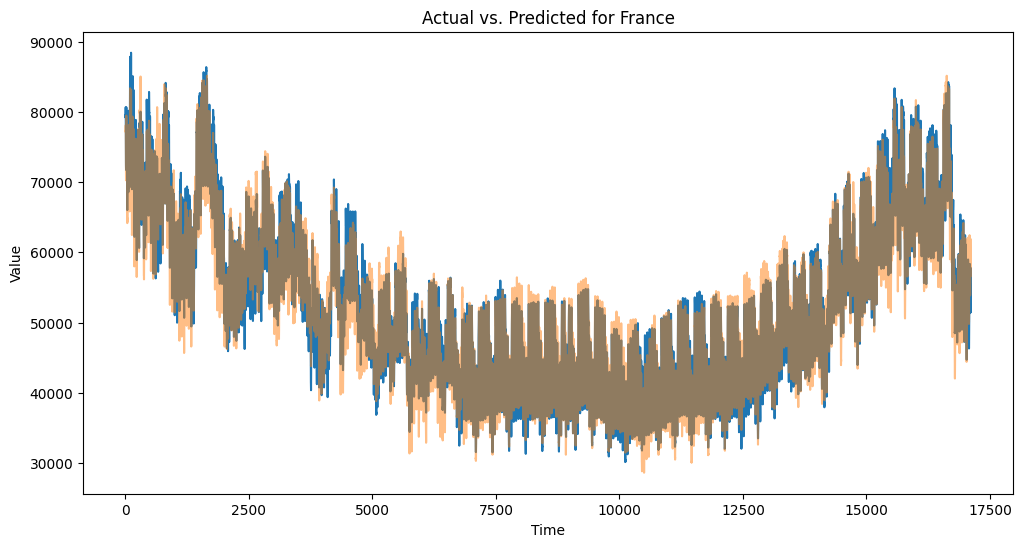

In [ ]:
# 加载原始 pred.csv
pred_df = pd.read_csv('8471.csv')

# 遍历所有大区进行预测并更新 pred.csv
for region in (france):
    predictions = train_and_predict(region, conso_df, weather_df, test_df)
    pred_df[f'pred_{region}'] = predictions

In [ ]:
# 保存最终的预测结果
pred_df.to_csv('./pred_final.csv', index=False)
print("All regions processed and predictions saved to pred.csv!")

All regions processed and predictions saved to pred.csv!


In [ ]:
# 加载原始 pred.csv
pred_df = pd.read_csv('8471.csv')

# 遍历所有大区进行预测并更新 pred.csv
for region in tqdm(france, desc='Processing regions', unit='region'):
    predictions = train_and_predict(region, conso_df, weather_df, test_df)
    pred_df[f'pred_{region}'] = predictions

# 保存最终的预测结果
pred_df.to_csv('./pred_final.csv', index=False)
print("All regions processed and predictions saved to pred.csv!")

Processing regions:   0%|          | 0/1 [00:00<?, ?region/s]

['Month', 'Year', 'Day', 'Hour', 'Week', 'Weekday', 'toy', 'is_holiday', 'is_summer_vacation', 'vacances', 'big_holiday', 'is_pandemic', 'Season', 'is_weekend', 'is_workday', 'is_transday', 'is_vacation', 'sin_Hour_k1', 'cos_Hour_k1', 'sin_Hour_k2', 'cos_Hour_k2', 'sin_Hour_k3', 'cos_Hour_k3', 'sin_Hour_k4', 'cos_Hour_k4', 'sin_Hour_k5', 'cos_Hour_k5', 'sin_Hour_k6', 'cos_Hour_k6', 'sin_Hour_k7', 'cos_Hour_k7', 'sin_Hour_k8', 'cos_Hour_k8', 'sin_Hour_k9', 'cos_Hour_k9', 'sin_Hour_k10', 'cos_Hour_k10', 'sin_Hour_k11', 'cos_Hour_k11', 'sin_Hour_k12', 'cos_Hour_k12', 'sin_Hour_k13', 'cos_Hour_k13', 'sin_Hour_k14', 'cos_Hour_k14', 'sin_Hour_k15', 'cos_Hour_k15', 'sin_Hour_k16', 'cos_Hour_k16', 'sin_Hour_k17', 'cos_Hour_k17', 'sin_Hour_k18', 'cos_Hour_k18', 'sin_Hour_k19', 'cos_Hour_k19', 'sin_Hour_k20', 'cos_Hour_k20', 'sin_Hour_k21', 'cos_Hour_k21', 'sin_Hour_k22', 'cos_Hour_k22', 'sin_Hour_k23', 'cos_Hour_k23', 'sin_Hour_k24', 'cos_Hour_k24', 'sin_Weekday_k1', 'cos_Weekday_k1', 'sin_Week


Training France:   0%|          | 0/300 [00:00<?, ?epoch/s]

Epoch 1/300, Train Loss: 54565.7634, Validation Loss: 49859.6516
Epoch 2/300, Train Loss: 40584.0741, Validation Loss: 17949.2557
Epoch 3/300, Train Loss: 7150.2392, Validation Loss: 4592.2625
Epoch 4/300, Train Loss: 5272.1445, Validation Loss: 4194.4263
Epoch 5/300, Train Loss: 5039.2800, Validation Loss: 3833.1776
Epoch 6/300, Train Loss: 4888.9200, Validation Loss: 3718.0142
Epoch 7/300, Train Loss: 4784.5688, Validation Loss: 3409.6051
Epoch 8/300, Train Loss: 4673.3265, Validation Loss: 3269.7550
Epoch 9/300, Train Loss: 4623.1852, Validation Loss: 3207.1493
Epoch 10/300, Train Loss: 4573.7675, Validation Loss: 3210.3984
Epoch 11/300, Train Loss: 4542.8108, Validation Loss: 3132.6194
Epoch 12/300, Train Loss: 4508.1222, Validation Loss: 2979.8812
Epoch 13/300, Train Loss: 4465.6075, Validation Loss: 2803.5415



Training France:   5%|▍         | 14/300 [00:14<04:46,  1.00s/epoch]

Epoch 14/300, Train Loss: 4453.7099, Validation Loss: 2781.2571



Training France:   5%|▌         | 15/300 [00:15<04:50,  1.02s/epoch]

Epoch 15/300, Train Loss: 4424.1253, Validation Loss: 2908.6844



Training France:   5%|▌         | 16/300 [00:16<04:47,  1.01s/epoch]

Epoch 16/300, Train Loss: 4399.2676, Validation Loss: 2780.9504



Training France:   6%|▌         | 17/300 [00:17<04:44,  1.00s/epoch]

Epoch 17/300, Train Loss: 4367.0465, Validation Loss: 2601.8112



Training France:   6%|▌         | 18/300 [00:18<04:42,  1.00s/epoch]

Epoch 18/300, Train Loss: 4355.1898, Validation Loss: 2618.2636



Training France:   6%|▋         | 19/300 [00:19<04:50,  1.04s/epoch]

Epoch 19/300, Train Loss: 4315.8863, Validation Loss: 2696.8015



Training France:   7%|▋         | 20/300 [00:20<04:45,  1.02s/epoch]

Epoch 20/300, Train Loss: 4316.7510, Validation Loss: 2834.0805



Training France:   7%|▋         | 21/300 [00:21<04:42,  1.01s/epoch]

Epoch 21/300, Train Loss: 4294.8045, Validation Loss: 2643.7674



Training France:   7%|▋         | 22/300 [00:22<04:50,  1.05s/epoch]

Epoch 22/300, Train Loss: 4309.4186, Validation Loss: 2568.4032



Training France:   8%|▊         | 23/300 [00:23<04:44,  1.03s/epoch]

Epoch 23/300, Train Loss: 4273.4418, Validation Loss: 2610.4085



Training France:   8%|▊         | 24/300 [00:24<04:38,  1.01s/epoch]

Epoch 24/300, Train Loss: 4244.1800, Validation Loss: 2683.7386



Training France:   8%|▊         | 25/300 [00:25<04:33,  1.01epoch/s]

Epoch 25/300, Train Loss: 4251.2501, Validation Loss: 2440.7961



Training France:   9%|▊         | 26/300 [00:26<04:29,  1.02epoch/s]

Epoch 26/300, Train Loss: 4207.0206, Validation Loss: 2498.0868



Training France:   9%|▉         | 27/300 [00:27<04:28,  1.02epoch/s]

Epoch 27/300, Train Loss: 4214.8954, Validation Loss: 2462.3503



Training France:   9%|▉         | 28/300 [00:28<04:25,  1.03epoch/s]

Epoch 28/300, Train Loss: 4213.8865, Validation Loss: 2554.2552



Training France:  10%|▉         | 29/300 [00:29<04:39,  1.03s/epoch]

Epoch 29/300, Train Loss: 4186.3325, Validation Loss: 2445.0553



Training France:  10%|█         | 30/300 [00:30<04:34,  1.02s/epoch]

Epoch 30/300, Train Loss: 4173.3426, Validation Loss: 2598.3401



Training France:  10%|█         | 31/300 [00:31<04:28,  1.00epoch/s]

Epoch 31/300, Train Loss: 4141.6913, Validation Loss: 2592.2852



Training France:  11%|█         | 32/300 [00:32<04:25,  1.01epoch/s]

Epoch 32/300, Train Loss: 4161.9742, Validation Loss: 2433.1400



Training France:  11%|█         | 33/300 [00:33<04:22,  1.02epoch/s]

Epoch 33/300, Train Loss: 4165.6415, Validation Loss: 2497.7537



Training France:  11%|█▏        | 34/300 [00:34<04:22,  1.01epoch/s]

Epoch 34/300, Train Loss: 4139.2044, Validation Loss: 2542.5994



Training France:  12%|█▏        | 35/300 [00:35<04:18,  1.03epoch/s]

Epoch 35/300, Train Loss: 4151.4578, Validation Loss: 2422.7965



Training France:  12%|█▏        | 36/300 [00:36<04:32,  1.03s/epoch]

Epoch 36/300, Train Loss: 4126.3603, Validation Loss: 2369.4633



Training France:  12%|█▏        | 37/300 [00:37<04:25,  1.01s/epoch]

Epoch 37/300, Train Loss: 4137.0386, Validation Loss: 2414.7133



Training France:  13%|█▎        | 38/300 [00:38<04:21,  1.00epoch/s]

Epoch 38/300, Train Loss: 4143.4340, Validation Loss: 2511.5138



Training France:  13%|█▎        | 39/300 [00:39<04:18,  1.01epoch/s]

Epoch 39/300, Train Loss: 4110.1983, Validation Loss: 2311.7470



Training France:  13%|█▎        | 40/300 [00:40<04:17,  1.01epoch/s]

Epoch 40/300, Train Loss: 4094.4950, Validation Loss: 2635.2287



Training France:  14%|█▎        | 41/300 [00:41<04:14,  1.02epoch/s]

Epoch 41/300, Train Loss: 4082.6607, Validation Loss: 2383.1870



Training France:  14%|█▍        | 42/300 [00:42<04:13,  1.02epoch/s]

Epoch 42/300, Train Loss: 4101.4471, Validation Loss: 2477.2880



Training France:  14%|█▍        | 43/300 [00:43<04:25,  1.03s/epoch]

Epoch 43/300, Train Loss: 4095.5324, Validation Loss: 2338.8017



Training France:  15%|█▍        | 44/300 [00:44<04:19,  1.01s/epoch]

Epoch 44/300, Train Loss: 4083.9518, Validation Loss: 2465.2268



Training France:  15%|█▌        | 45/300 [00:45<04:15,  1.00s/epoch]

Epoch 45/300, Train Loss: 4086.0030, Validation Loss: 2513.6934



Training France:  15%|█▌        | 46/300 [00:46<04:10,  1.01epoch/s]

Epoch 46/300, Train Loss: 4094.6444, Validation Loss: 2631.6637



Training France:  16%|█▌        | 47/300 [00:47<04:07,  1.02epoch/s]

Epoch 47/300, Train Loss: 4072.2049, Validation Loss: 2711.6035



Training France:  16%|█▌        | 48/300 [00:48<04:05,  1.03epoch/s]

Epoch 48/300, Train Loss: 4067.4359, Validation Loss: 2869.2808



Training France:  16%|█▋        | 49/300 [00:49<04:18,  1.03s/epoch]

Epoch 49/300, Train Loss: 4078.7782, Validation Loss: 2684.1376



Training France:  17%|█▋        | 50/300 [00:50<04:13,  1.01s/epoch]

Epoch 50/300, Train Loss: 4052.3492, Validation Loss: 2715.2104



Training France:  17%|█▋        | 51/300 [00:51<04:09,  1.00s/epoch]

Epoch 51/300, Train Loss: 4062.5034, Validation Loss: 2553.0576



Processing regions:   0%|          | 0/1 [00:53<?, ?region/s]


KeyboardInterrupt: 

In [ ]:
# 加载原始 pred.csv
pred_df = pd.read_csv('8568.csv')

# 遍历所有大区进行预测并更新 pred.csv
for region in tqdm(regions, desc='Processing regions', unit='region'):
    predictions = train_and_predict(region, conso_df, weather_df, test_df)
    pred_df[f'pred_{region}'] = predictions

# 保存最终的预测结果
pred_df.to_csv('./pred_final.csv', index=False)
print("All regions processed and predictions saved to pred.csv!")

Processing regions:   8%|▊         | 1/12 [01:05<11:59, 65.40s/region]

Early stopping triggered after 61 epochs. Best Validation Loss: 314.9292
Best model restored for final evaluation.



Processing regions:  17%|█▋        | 2/12 [02:08<10:37, 63.77s/region]

Early stopping triggered after 59 epochs. Best Validation Loss: 113.2915
Best model restored for final evaluation.



Processing regions:  25%|██▌       | 3/12 [03:11<09:31, 63.47s/region]

Early stopping triggered after 59 epochs. Best Validation Loss: 164.7018
Best model restored for final evaluation.



Processing regions:  33%|███▎      | 4/12 [04:12<08:22, 62.77s/region]

Early stopping triggered after 58 epochs. Best Validation Loss: 121.8266
Best model restored for final evaluation.



Processing regions:  42%|████▏     | 5/12 [05:30<07:56, 68.06s/region]

Early stopping triggered after 72 epochs. Best Validation Loss: 222.3355
Best model restored for final evaluation.



Processing regions:  50%|█████     | 6/12 [06:34<06:39, 66.63s/region]

Early stopping triggered after 60 epochs. Best Validation Loss: 240.8626
Best model restored for final evaluation.



Processing regions:  58%|█████▊    | 7/12 [07:37<05:27, 65.48s/region]

Early stopping triggered after 59 epochs. Best Validation Loss: 138.4447
Best model restored for final evaluation.



Processing regions:  67%|██████▋   | 8/12 [08:44<04:23, 65.93s/region]

Early stopping triggered after 62 epochs. Best Validation Loss: 229.0880
Best model restored for final evaluation.



Processing regions:  75%|███████▌  | 9/12 [09:55<03:23, 67.72s/region]

Early stopping triggered after 67 epochs. Best Validation Loss: 218.9029
Best model restored for final evaluation.



Processing regions:  83%|████████▎ | 10/12 [12:06<02:54, 87.16s/region]

Early stopping triggered after 123 epochs. Best Validation Loss: 173.6109
Best model restored for final evaluation.



Processing regions:  92%|█████████▏| 11/12 [13:00<01:17, 77.01s/region]

Early stopping triggered after 51 epochs. Best Validation Loss: 216.1129
Best model restored for final evaluation.



 19%|█▉        | 57/300 [01:00<04:05,  1.01s/it]


In [ ]:
for region in tqdm(metropoles, desc='Processing regions', unit='region'):
    predictions = train_and_predict(region, conso_df, weather_df, test_df)
    pred_df[f'pred_{region}'] = predictions

# 保存最终的预测结果
pred_df.to_csv('./pred_final.csv', index=False)
print("All regions processed and predictions saved to pred.csv!")

Processing regions:  14%|█▍        | 1/7 [00:46<04:37, 46.31s/region]

Early stopping triggered after 43 epochs. Best Validation Loss: 44.5574
Best model restored for final evaluation.



Processing regions:  29%|██▊       | 2/7 [01:56<05:02, 60.44s/region]

Early stopping triggered after 66 epochs. Best Validation Loss: 76.7416
Best model restored for final evaluation.



Processing regions:  43%|████▎     | 3/7 [03:01<04:09, 62.39s/region]

Early stopping triggered after 59 epochs. Best Validation Loss: 34.1306
Best model restored for final evaluation.



Processing regions:  57%|█████▋    | 4/7 [03:47<02:47, 55.96s/region]

Early stopping triggered after 43 epochs. Best Validation Loss: 105.5449
Best model restored for final evaluation.



Processing regions:  71%|███████▏  | 5/7 [05:12<02:12, 66.33s/region]

Early stopping triggered after 79 epochs. Best Validation Loss: 241.0521
Best model restored for final evaluation.



Processing regions:  86%|████████▌ | 6/7 [06:12<01:04, 64.18s/region]

Early stopping triggered after 56 epochs. Best Validation Loss: 35.6101
Best model restored for final evaluation.



Processing regions: 100%|██████████| 7/7 [07:09<00:00, 61.30s/region]

Early stopping triggered after 54 epochs. Best Validation Loss: 36.3189
Best model restored for final evaluation.


All regions processed and predictions saved to pred.csv!


In [47]:
def train_and_predictAll(train_data, test_data, model, target_columns, epochs=50, batch_size=256, lr=0.0001):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 📌 需要预测的 25 个区域
    # target_columns = [
    #     "France", "Auvergne-Rhône-Alpes", "Bourgogne-Franche-Comté", "Bretagne",
    #     "Centre-Val de Loire", "Grand Est", "Hauts-de-France", "Normandie",
    #     "Nouvelle-Aquitaine", "Occitanie", "Pays de la Loire", "Provence-Alpes-Côte d'Azur",
    #     "Île-de-France", "Montpellier Méditerranée Métropole", "Métropole Européenne de Lille",
    #     "Métropole Grenoble-Alpes-Métropole", "Métropole Nice Côte d'Azur", "Métropole Rennes Métropole",
    #     "Métropole Rouen Normandie", "Métropole d'Aix-Marseille-Provence", "Métropole de Lyon",
    #     "Métropole du Grand Nancy", "Métropole du Grand Paris", "Nantes Métropole", "Toulouse Métropole"
    # ]

    # 📌 1. 预处理 `X_train` 和 `y_train`
    X_train = train_data.drop(columns=list(target_columns)).values
    y_train = train_data[target_columns].values

    # 📌 2. 预处理 `X_test`（注意 `test_data` 没有 target）
    X_test = test_data.values

    # 📌 3. 标准化 X 和 y
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)  # 训练集 X 归一化
    X_test_scaled = scaler_X.transform(X_test)  # 测试集 X 也要归一化
    print(X_train_scaled.shape)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)  # 训练集 y 归一化
    print(y_train_scaled.shape)

    # 📌 4. 划分训练集和验证集（80% 训练，20% 验证）
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)

    # 📌 5. 转换为 PyTorch 张量
    X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_split = torch.tensor(y_train_split, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    # 📌 6. 创建 DataLoader
    train_dataset = TensorDataset(X_train_split, y_train_split)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 📌 7. 初始化模型、优化器、损失函数
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = RMSE

    train_losses = []
    val_losses = []

    # 📌 8. 训练模型
    model.train()
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            pred = model(batch_X)  # 预测

            # loss = loss_fn(pred, batch_y)  # 计算损失
            # loss.backward()

            # ⚠️ 不使用 numpy，直接在 PyTorch 中反标准化
            pred_real = pred * torch.tensor(scaler_y.scale_, device=device) + torch.tensor(scaler_y.mean_, device=device)
            batch_y_real = batch_y * torch.tensor(scaler_y.scale_, device=device) + torch.tensor(scaler_y.mean_, device=device)

            # 计算 RMSE 损失
            loss = torch.sqrt(torch.mean((pred_real - batch_y_real) ** 2))

            # 反向传播
            loss.backward()

            optimizer.step()
            train_loss += loss.item()
            #print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # 📌 计算验证集损失
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val.to(device))
            # 反标准化验证集
            val_pred_real = val_pred * torch.tensor(scaler_y.scale_, device=device) + torch.tensor(scaler_y.mean_, device=device)
            y_val_real = y_val * torch.tensor(scaler_y.scale_, device=device) + torch.tensor(scaler_y.mean_, device=device)

            # 验证损失
            val_loss = torch.sqrt(torch.mean((val_pred_real - y_val_real) ** 2))

        val_losses.append(val_loss.item())


        # 📌 打印训练过程
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # 📌 9. 绘制损失曲线
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    # 📌 10. 用 `test_data` 进行最终预测，并反标准化
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor.to(device)).cpu().numpy()
        y_pred_real = scaler_y.inverse_transform(y_pred_scaled)  # 反标准化

    # 📌 11. 存储预测结果到 `pred.csv`
    # 读取现有的 .csv
    original_pred_df = pd.read_csv("8568.csv")
    # 预测结果 DataFrame
    pred_df = pd.DataFrame(y_pred_real, columns=["pred_" + c for c in target_columns])
    # 替换同名列
    for col in pred_df.columns:
        if col in original_pred_df.columns:
            original_pred_df[col] = pred_df[col]
        else:
            print(f" 列 {col} 在原始 pred.csv 中不存在，已跳过。")
    # 保存替换后的 pred.csv
    original_pred_df.to_csv("pred.csv", index=False)
    print("测试集预测完成，结果已成功替换到 pred.csv！")

    return model


In [95]:
def train_and_predictAll(train_data, test_data, model, target_columns, epochs=50, batch_size=256, lr=0.0001):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 1. 预处理 X_train 和 y_train
    X_train = train_data.drop(columns=list(target_columns)).values
    y_train = train_data[target_columns].values

    # 2. 预处理 X_test
    X_test = test_data.values

    # 3. 标准化 X 和 y
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)

    # 将 scaler 的参数移至 CUDA
    scale_tensor = torch.tensor(scaler_y.scale_, dtype=torch.float32, device=device)
    mean_tensor = torch.tensor(scaler_y.mean_, dtype=torch.float32, device=device)

    # 4. 划分训练集和验证集
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)

    # 5. 转换为 PyTorch 张量
    X_train_split = torch.tensor(X_train_split, dtype=torch.float32, device=device)
    y_train_split = torch.tensor(y_train_split, dtype=torch.float32, device=device)
    X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
    y_val = torch.tensor(y_val, dtype=torch.float32, device=device)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)

    # 6. 创建 DataLoader
    train_dataset = TensorDataset(X_train_split, y_train_split)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 7. 初始化模型、优化器、损失函数
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5)
    loss_fn = RMSE

    train_losses = []
    val_losses = []

    # 8. 训练模型
    model.train()
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            pred = model(batch_X)

            # 反标准化
            pred_real = pred * scale_tensor + mean_tensor
            batch_y_real = batch_y * scale_tensor + mean_tensor

            # 计算 RMSE 损失
            #loss = torch.sqrt(torch.mean((pred_real - batch_y_real) ** 2))
            loss = loss_fn(pred_real, batch_y_real)

            # 反向传播
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # 计算验证集损失
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_pred_real = val_pred * scale_tensor + mean_tensor
            y_val_real = y_val * scale_tensor + mean_tensor
            val_loss = torch.sqrt(torch.mean((val_pred_real - y_val_real) ** 2))

        val_losses.append(val_loss.item())

        # 打印训练过程
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # 9. 绘制损失曲线
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    # 10. 生成测试集预测
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor)
        y_pred_real = y_pred_scaled * scale_tensor + mean_tensor

    # 11. 保存预测结果到 pred.csv
    original_pred_df = pd.read_csv("8568.csv")
    pred_df = pd.DataFrame(y_pred_real.cpu().numpy(), columns=["pred_" + c for c in target_columns])

    for col in pred_df.columns:
        if col in original_pred_df.columns:
            original_pred_df[col] = pred_df[col]
        else:
            print(f"列 {col} 在原始 pred.csv 中不存在，已跳过。")

    original_pred_df.to_csv("pred.csv", index=False)
    print("测试集预测完成，结果已成功替换到 pred.csv！")

    return model


In [96]:
merged_data = conso_df.merge(weather_df, on='date', how='left')
test_data = test_df.merge(weather_df, on='date', how='left')

In [97]:
merged_data = merged_data.select_dtypes(exclude=['datetime64[ns, UTC]'])
test_data = test_data.select_dtypes(exclude=['datetime64[ns, UTC]'])

In [98]:
drop_features = [ 'Day', 'Hour', 'Week', 'toy', 'Minute', 'Half_Hour']
# 从 merged_data 和 test_data 中移除这些列
merged_data = merged_data.drop(columns=drop_features, errors='ignore')
test_data = test_data.drop(columns=drop_features, errors='ignore')

In [99]:
# 去除列名可能的前后
merged_data.columns.tolist()

['France',
 'Auvergne-Rhône-Alpes',
 'Bourgogne-Franche-Comté',
 'Bretagne',
 'Centre-Val de Loire',
 'Grand Est',
 'Hauts-de-France',
 'Normandie',
 'Nouvelle-Aquitaine',
 'Occitanie',
 'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur",
 'Île-de-France',
 'Montpellier Méditerranée Métropole',
 'Métropole Européenne de Lille',
 'Métropole Grenoble-Alpes-Métropole',
 "Métropole Nice Côte d'Azur",
 'Métropole Rennes Métropole',
 'Métropole Rouen Normandie',
 "Métropole d'Aix-Marseille-Provence",
 'Métropole de Lyon',
 'Métropole du Grand Nancy',
 'Métropole du Grand Paris',
 'Nantes Métropole',
 'Toulouse Métropole',
 'Month',
 'Year',
 'Weekday',
 'is_holiday',
 'is_summer_vacation',
 'vacances',
 'big_holiday',
 'is_pandemic',
 'Season',
 'is_weekend',
 'is_workday',
 'is_transday',
 'is_vacation',
 'sin_Half_Hour_k1',
 'cos_Half_Hour_k1',
 'sin_Half_Hour_k2',
 'cos_Half_Hour_k2',
 'sin_Half_Hour_k3',
 'cos_Half_Hour_k3',
 'sin_Half_Hour_k4',
 'cos_Half_Hour_k4',
 'sin_Half_Hour_k5',
 

In [100]:
target_columns = ['France','Auvergne-Rhône-Alpes','Bourgogne-Franche-Comté','Bretagne','Centre-Val de Loire',
 'Grand Est','Hauts-de-France','Normandie','Nouvelle-Aquitaine','Occitanie','Pays de la Loire',"Provence-Alpes-Côte d'Azur",
 'Île-de-France','Montpellier Méditerranée Métropole','Métropole Européenne de Lille','Métropole Grenoble-Alpes-Métropole',
 "Métropole Nice Côte d'Azur",'Métropole Rennes Métropole','Métropole Rouen Normandie',"Métropole d'Aix-Marseille-Provence",
 'Métropole de Lyon','Métropole du Grand Nancy','Métropole du Grand Paris','Nantes Métropole','Toulouse Métropole']

In [101]:
input_dim = merged_data.shape[1] - len(target_columns)
print("input dim : ", input_dim)  # 预计应该是 420

input dim :  603


  2%|▎         | 1/40 [00:01<00:42,  1.09s/it]

Epoch 0, Train Loss: 1137.6730, Val Loss: 710.0406


 28%|██▊       | 11/40 [00:10<00:27,  1.07it/s]

Epoch 10, Train Loss: 144.2012, Val Loss: 196.6054


 52%|█████▎    | 21/40 [00:19<00:17,  1.11it/s]

Epoch 20, Train Loss: 108.4358, Val Loss: 160.4840


 78%|███████▊  | 31/40 [00:28<00:08,  1.07it/s]

Epoch 30, Train Loss: 92.4614, Val Loss: 144.1232


100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


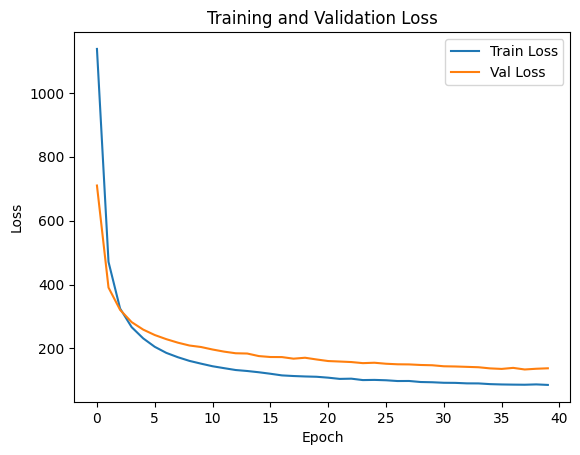

测试集预测完成，结果已成功替换到 pred.csv！


In [104]:
model = MLPWithAttentionAll(input_dim)
trained_model = train_and_predictAll(merged_data, test_data, model,target_columns, epochs=35, batch_size=512, lr=0.0001)

In [ ]:
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train_and_predict(train_data, test_data, model, epochs=50, batch_size=256, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 需要预测的 25 个地区
    target_columns = [
        "France", "Auvergne-Rhône-Alpes", "Bourgogne-Franche-Comté", "Bretagne",
        "Centre-Val de Loire", "Grand Est", "Hauts-de-France", "Normandie",
        "Nouvelle-Aquitaine", "Occitanie", "Pays de la Loire", "Provence-Alpes-Côte d'Azur",
        "Île-de-France", "Montpellier Méditerranée Métropole", "Métropole Européenne de Lille",
        "Métropole Grenoble-Alpes-Métropole", "Métropole Nice Côte d'Azur", "Métropole Rennes Métropole",
        "Métropole Rouen Normandie", "Métropole d'Aix-Marseille-Provence", "Métropole de Lyon",
        "Métropole du Grand Nancy", "Métropole du Grand Paris", "Nantes Métropole", "Toulouse Métropole"
    ]

    # 处理输入特征（去掉日期和目标列）
    X_train = train_data.drop(columns=['date'] + target_columns).values  # 训练特征
    y_train = train_data[target_columns].values  # 目标值 25 维

    X_test = test_data.drop(columns=['date']).values  # 预测时不需要目标列

    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    # 创建数据集
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 初始化模型
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # 训练
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = loss_fn(pred, batch_y)
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    # 预测
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.to(device)).cpu().numpy()

    # 存储预测结果
    pred_df = pd.read_csv("pred.csv")
    for i, col in enumerate(["pred_" + c for c in target_columns]):
        pred_df[col] = predictions[:, i]  # 逐列填充预测值

    pred_df.to_csv("pred.csv", index=False)
    print("预测完成，已保存到 pred.csv")

    return model
